In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [16]:
# Function for Sobel edge detection
def sobel_edges(image):
    # Normalize image to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    
    # Convert image to grayscale
    gray = tf.image.rgb_to_grayscale(image)
    
    # Calculate gradients using Sobel filter
    grad_x = tf.image.sobel_edges(gray)[..., 0]
    grad_y = tf.image.sobel_edges(gray)[..., 1]

    # Compute gradient magnitude
    edges = tf.sqrt(tf.square(grad_x) + tf.square(grad_y))

    # Normalize edges to [0, 1]
    edges = (edges - tf.reduce_min(edges)) / (tf.reduce_max(edges) - tf.reduce_min(edges) + 1e-6)

    # Resize edges to 64x64
    edges = tf.image.resize(edges, [64, 64])

    # Ensure the edges tensor has 3 dimensions
    edges = tf.expand_dims(edges, axis=-1)

    return edges

In [17]:
# Function to load and preprocess datasets with label prefix
def load_and_preprocess_dataset(directory, label_offset):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',  # Use integer labels
        color_mode='rgb',
        batch_size=32,
        image_size=(64, 64),
        shuffle=True
    )

    dataset = dataset.map(lambda x, y: (sobel_edges(x), y + label_offset))
    return dataset

In [18]:
# Function to count number of subdirectories (classes) in a directory
def count_classes(directory):
    return len(os.listdir(directory))

In [19]:
# Count classes to determine offsets
num_fraud_classes = count_classes('D:/Users/rafae/Desktop/signiture/fraud/training')
num_legit_classes = count_classes('D:/Users/rafae/Desktop/signiture/legit/training')

In [20]:
# Load datasets with offsets and apply Sobel edges
training_set_fraud = load_and_preprocess_dataset('D:/Users/rafae/Desktop/signiture/fraud/training', 0)
validation_set_fraud = load_and_preprocess_dataset('D:/Users/rafae/Desktop/signiture/fraud/validation', 0)
training_set_legit = load_and_preprocess_dataset('D:/Users/rafae/Desktop/signiture/legit/training', num_fraud_classes)
validation_set_legit = load_and_preprocess_dataset('D:/Users/rafae/Desktop/signiture/legit/validation', num_fraud_classes)

Found 24 files belonging to 4 classes.


Found 16 files belonging to 4 classes.
Found 24 files belonging to 4 classes.
Found 16 files belonging to 4 classes.


In [21]:
# Combine the datasets
combined_training_set = training_set_fraud.concatenate(training_set_legit)
combined_validation_set = validation_set_fraud.concatenate(validation_set_legit)

In [22]:
# Define the CNN model
cnn_combined = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 1]),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=num_fraud_classes + num_legit_classes, activation='softmax')
])

In [23]:
# Compile the model
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

cnn_combined.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy
    metrics=['accuracy']
)

In [24]:
# Early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

In [25]:
# Train the model
training_history_combined = cnn_combined.fit(combined_training_set, epochs=20, validation_data=combined_validation_set, callbacks=[early_stopping_callback])

Epoch 1/20
2/2 [==============================] - 3s 694ms/step - loss: 2.7668 - accuracy: 0.0000e+00 - val_loss: 2.4639 - val_accuracy: 0.1562
Epoch 2/20
2/2 [==============================] - 1s 420ms/step - loss: 2.3994 - accuracy: 0.2292 - val_loss: 1.9667 - val_accuracy: 0.1250
Epoch 3/20
2/2 [==============================] - 1s 425ms/step - loss: 1.9421 - accuracy: 0.1458 - val_loss: 1.4681 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 1s 411ms/step - loss: 1.2984 - accuracy: 0.4792 - val_loss: 0.8518 - val_accuracy: 0.7188
Epoch 5/20
2/2 [==============================] - 1s 386ms/step - loss: 1.1885 - accuracy: 0.5833 - val_loss: 0.5137 - val_accuracy: 0.9062
Epoch 6/20
2/2 [==============================] - 1s 388ms/step - loss: 0.5744 - accuracy: 0.7917 - val_loss: 0.2794 - val_accuracy: 0.9062
Epoch 7/20
2/2 [==============================] - 1s 372ms/step - loss: 0.5391 - accuracy: 0.8750 - val_loss: 0.1374 - val_accuracy: 0.9688
Epoch 8/20
2/2 [

In [26]:
# Save the model
cnn_combined.save('trained_combined_signature_model_with_sobel.h5')

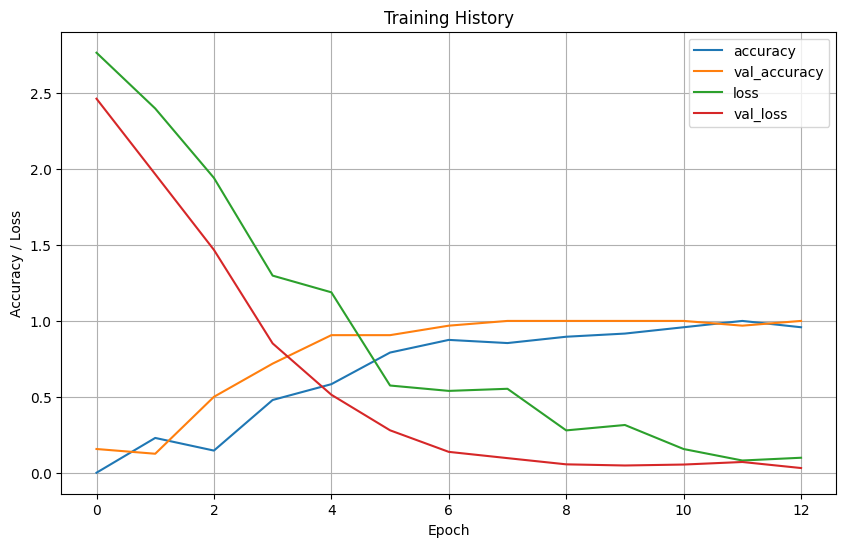

In [27]:
# Visualize training history
plt.figure(figsize=(10, 6))
plt.plot(training_history_combined.history['accuracy'], label='accuracy')
plt.plot(training_history_combined.history['val_accuracy'], label='val_accuracy')
plt.plot(training_history_combined.history['loss'], label='loss')
plt.plot(training_history_combined.history['val_loss'], label='val_loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)
plt.show()

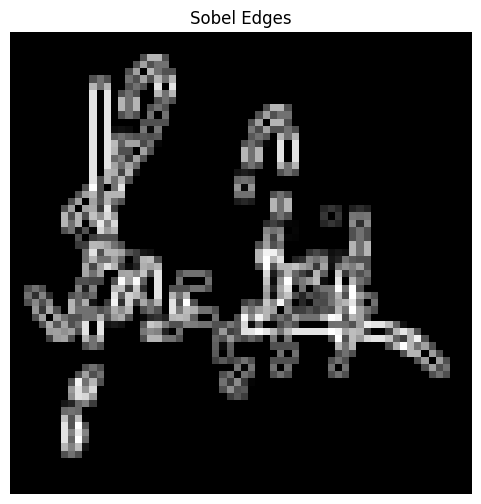

In [28]:
# Load an example image after Sobel edge detection
for images, labels in combined_training_set.take(1):
    sobel_image = images[0]  # Take the first image from the batch
    
    # Display the Sobel edge detected image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.squeeze(sobel_image), cmap='gray')
    plt.title('Sobel Edges')
    plt.axis('off')
    plt.show()